In [3]:
import scipy,io
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, SimpleRNN, Input, TimeDistributed, GRU, LSTM, Bidirectional
from tensorflow.keras.optimizers import AdamW, RMSprop, Nadam, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.regularizers import L1, L2
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, PolynomialFeatures, StandardScaler, normalize, MinMaxScaler
from sklearn.decomposition import PCA
import math
import matplotlib.pyplot as plt
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification


X_scaler, y_scaler = MinMaxScaler(), MinMaxScaler()

# 10000 Samples
mat = scipy.io.loadmat('../UNT-Thermography-24/GaN_data/data_GaN_8_15micron_1.mat')
mat2 = scipy.io.loadmat('../UNT-Thermography-24/GaN_data/data_GaN_8_15micron_2.mat')
mat3 = scipy.io.loadmat('../UNT-Thermography-24/GaN_data/data_GaN_8_15micron_3.mat')

temp_comb = np.concatenate((mat.get('T_GaN_random'), mat2.get('T_GaN_random'), mat3.get('T_GaN_random')), axis=2)
spectra_comb = np.concatenate((mat.get('Spectrum'), mat2.get('Spectrum'), mat3.get('Spectrum')), axis=2)

samples = spectra_comb.shape[2]

reshaped_spectra = spectra_comb.reshape(-1, samples).T
reshaped_temp = temp_comb.reshape(-1, samples).T

temp_shape = temp_comb.shape
spectra_shape = spectra_comb.shape

# 50000 samples
mat4 = scipy.io.loadmat('../UNT-Thermography-24/GaN_data/data_GaN_8_15micron_4_10000.mat')
mat5 = scipy.io.loadmat('../UNT-Thermography-24/GaN_data/data_GaN_8_15micron_5_10000.mat')
mat6 = scipy.io.loadmat('../UNT-Thermography-24/GaN_data/data_GaN_8_15micron_6_10000.mat')
mat7 = scipy.io.loadmat('../UNT-Thermography-24/GaN_data/data_GaN_8_15micron_7_10000.mat')

temp_comb_all = np.concatenate((temp_comb, mat4.get('T_GaN_random'), mat5.get('T_GaN_random'), mat6.get('T_GaN_random'), mat7.get('T_GaN_random')), axis=2)
spectra_comb_all = np.concatenate((spectra_comb, mat4.get('Spectrum'), mat5.get('Spectrum'), mat6.get('Spectrum'), mat7.get('Spectrum')), axis=2)

samples_all = spectra_comb_all.shape[2]

spectra_all = spectra_comb_all.reshape(-1, samples).T
temp_all = temp_comb_all.reshape(-1, samples).T

spectra_shape = spectra_comb_all.shape
temp_shape = temp_comb_all.shape


# Train, test, validation split
X_train, X_test, y_train, y_test = train_test_split(spectra_all, temp_all, train_size=0.8, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.75, random_state=42)

X_train = X_train.T.reshape(spectra_shape[0], spectra_shape[1], -1)
X_val = X_val.T.reshape(spectra_shape[0], spectra_shape[1], -1)
X_test = X_test.T.reshape(spectra_shape[0], spectra_shape[1], -1)

y_train = y_train.T.reshape(temp_shape[0], temp_shape[1], -1)
y_val = y_val.T.reshape(temp_shape[0], temp_shape[1], -1)
y_test = y_test.T.reshape(temp_shape[0], temp_shape[1], -1)

X_train = X_train.transpose(2, 0, 1)
X_val = X_val.transpose(2, 0, 1)
X_test = X_test.transpose(2, 0, 1)

y_train = y_train.transpose(2, 0, 1)
y_val = y_val.transpose(2, 0, 1)
y_test = y_test.transpose(2, 0, 1)

# Fit and transform the input data (X_train)
X_train_scaled = X_scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)

# Transform the validation and test data using the same scaler
X_val_scaled = X_scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test_scaled = X_scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Fit and transform the output data (y_train)
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, y_train.shape[-1])).reshape(y_train.shape)

# Transform the validation and test data using the same scaler
y_val_scaled = y_scaler.transform(y_val.reshape(-1, y_val.shape[-1])).reshape(y_val.shape)
y_test_scaled = y_scaler.transform(y_test.reshape(-1, y_test.shape[-1])).reshape(y_test.shape)



In [4]:
model = Sequential()
model.add(Input(shape=(5, 71)))
# model.add(Bidirectional(LSTM(1024, activation='relu', return_sequences=True)))
model.add(Bidirectional(LSTM(512, activation='relu', return_sequences=True)))
model.add(Bidirectional(LSTM(256, activation='relu', return_sequences=True)))
model.add(Bidirectional(LSTM(128, activation='relu', return_sequences=True)))
model.add(Bidirectional(LSTM(64, activation='relu', return_sequences=True)))
model.add(Bidirectional(LSTM(32, activation='relu', return_sequences=True)))
model.add(Bidirectional(LSTM(16, activation='relu', return_sequences=True)))
model.add(Bidirectional(LSTM(8, activation='relu', return_sequences=True)))
model.add(TimeDistributed(Dense(10, activation='linear')))

model.summary()

nadam = Nadam(learning_rate=0.001)
adam = Adam(learning_rate=.001)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

model.compile(optimizer=nadam, loss='mae', metrics=['accuracy'])

history = model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=512, validation_data=(X_val_scaled, y_val_scaled),
          callbacks=[early_stopping, reduce_lr])


test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test_scaled)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_7 (Bidirectional) │ (None, 5, 1024)        │     2,392,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 5, 512)         │     2,623,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ (None, 5, 256)         │       656,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ (None, 5, 128)         │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 5, 64)          │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_12                │ (None, 5, 32)          │        10,368 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ (None, 5, 16)          │         2,624 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 5, 10)          │           170 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,890,666 (22.47 MB)

 Trainable params: 5,890,666 (22.47 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 28s 348ms/step - accuracy: 0.3110 - loss: 0.2593 - val_accuracy: 0.3831 - val_loss: 0.0591 - learning_rate: 0.0010
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 20s 338ms/step - accuracy: 0.3660 - loss: 0.0513 - val_accuracy: 0.3447 - val_loss: 0.0445 - learning_rate: 0.0010
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 21s 350ms/step - accuracy: 0.5277 - loss: 0.0396 - val_accuracy: 0.4177 - val_loss: 0.0367 - learning_rate: 0.0010
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 21s 362ms/step - accuracy: 0.6348 - loss: 0.0363 - val_accuracy: 0.7981 - val_loss: 0.0361 - learning_rate: 0.0010
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 21s 353ms/step - accuracy: 0.6357 - loss: 0.0350 - val_accuracy: 0.7644 - val_loss: 0.0350 - learning_rate: 0.0010
Epoch 6/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 21s 349ms/step - accuracy: 0.6957 - loss: 0.0341 - val_accuracy: 0.7476 - val_loss: 0.0336 - learning_rate: 0.0010
Epoch 7/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 21s 363ms/step - accuracy: 0.7160 - l

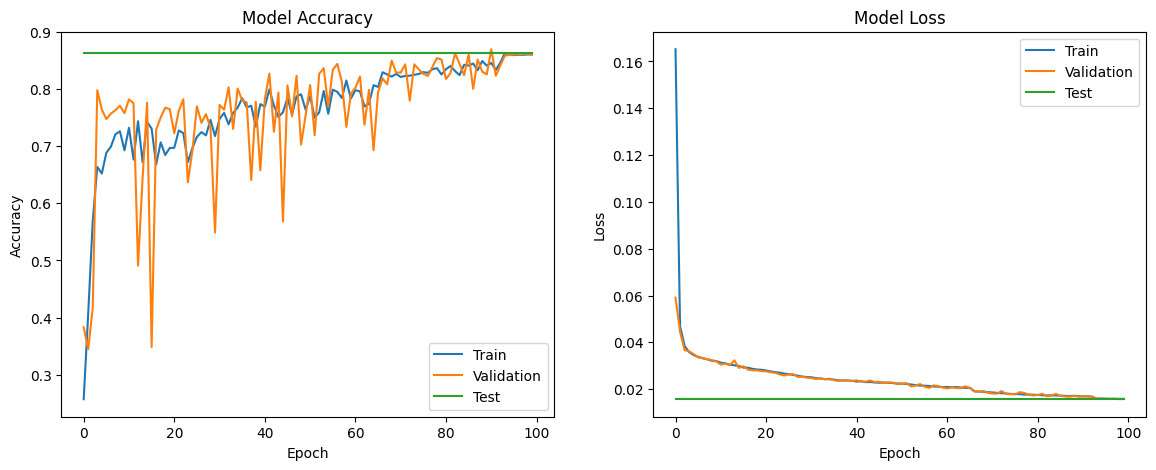

In [5]:
history.history['test_accuracy'] = [test_accuracy] * len(history.history['accuracy'])
history.history['test_loss'] = [test_loss] * len(history.history['loss'])

# Plot loss and accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.plot(history.history['test_accuracy'], label='Test')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.plot(history.history['test_loss'], label='Test')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()

In [6]:
# Make predictions
y_pred = model.predict(X_test_scaled)
print(f'Prediction shape: {y_pred.shape}')

# Reshape the predicted outputs to match the original shape
y_pred_rescaled = y_pred.reshape(-1, y_pred.shape[-1])

# Inverse transform the predicted outputs
y_pred_original_scale = y_scaler.inverse_transform(y_pred_rescaled).reshape(y_pred.shape)


313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step
Prediction shape: (10000, 5, 10)


In [7]:
# Select a random index for a 5x10 segment
random_index = np.random.randint(0, len(y_test))
actual_segment = y_test[random_index]
predicted_segment = y_pred_original_scale[random_index]

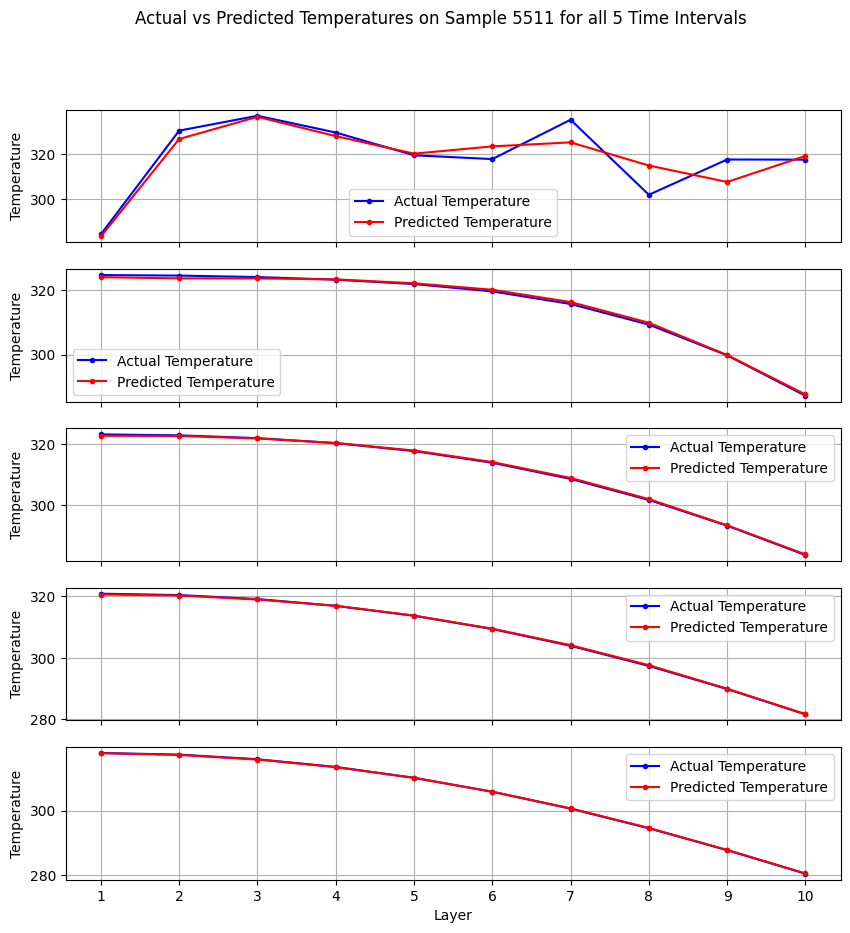

In [13]:
# Select a random index for a 5x10 segment
random_index = np.random.randint(0, len(y_test))
actual_segment = y_test[random_index]
predicted_segment = y_pred_original_scale[random_index]

x = range(1, 11)

# Plot the selected segments
fig, axs = plt.subplots(5, 1, figsize=(10, 10), sharex=True)
for i in range(5):
    axs[i].plot(x, actual_segment[i], 'b.-', label='Actual Temperature')
    axs[i].plot(x, predicted_segment[i], 'r.-', label='Predicted Temperature')
    plt.xlabel('Layer')
    plt.xticks(np.arange(1, 11, step=1))
    axs[i].set_ylabel('Temperature')
    axs[i].legend()
    axs[i].grid(True)

plt.xlabel('Layer')
plt.suptitle(f"Actual vs Predicted Temperatures on Sample {random_index} for all 5 Time Intervals")
plt.show()

In [9]:
# Calculate absolute difference
temp_diff_abs = np.abs(y_test - y_pred_original_scale)

In [15]:
y_test.shape

(10000, 5, 10)

In [19]:
# Sum all test matrices into one 5 by 10 matrix
temp_diff_2d = np.sum(temp_diff_abs, axis=0)

# Average absolute temperature difference per layer in each time instance
avg_temp_time = temp_diff_2d / 10000

# Sum columns together and find mean
avg_temp_diff = np.sum(temp_diff_2d, axis=0) / 50000

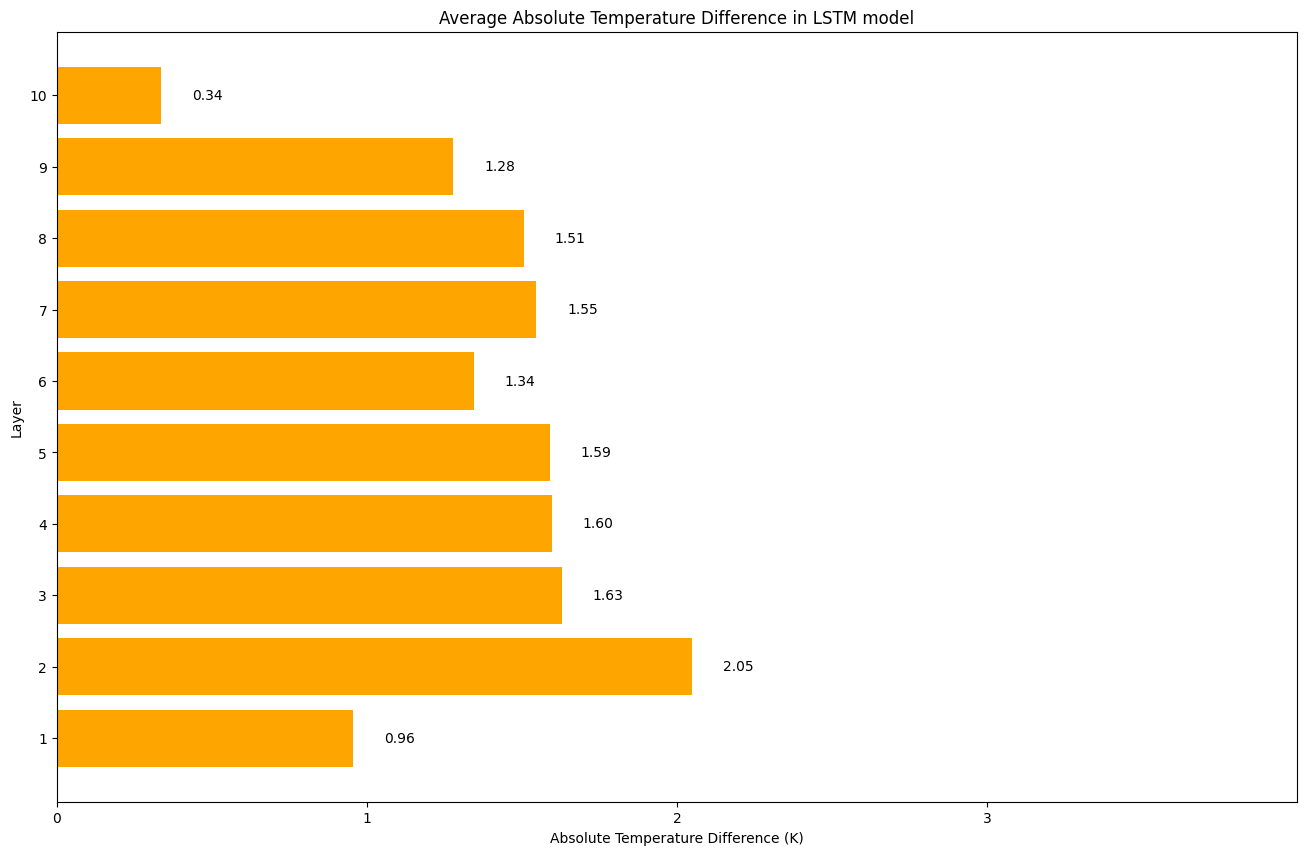

In [20]:
plt.figure(figsize=(16, 10))

# Plot horizontal bar graph
bars = plt.barh(x, avg_temp_diff, color='orange')

# Set the x-axis limits if needed
plt.xlim(math.floor(np.min(avg_temp_diff)), math.ceil(np.max(avg_temp_diff)) + 1)

# Add title and labels
plt.title("Average Absolute Temperature Difference in LSTM model")
plt.ylabel("Layer")
plt.xlabel("Absolute Temperature Difference (K)")

# Set y-ticks for layers
plt.yticks(np.arange(1, 11, step=1))

# Set x-ticks for temperature difference
plt.xticks(np.arange(math.floor(np.min(avg_temp_diff)), math.ceil(np.max(avg_temp_diff)) + 1, step=1))

# Add labels to each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.1, bar.get_y() + bar.get_height() / 2, f'{width:.2f}', 
             ha='left', va='center')

plt.show()

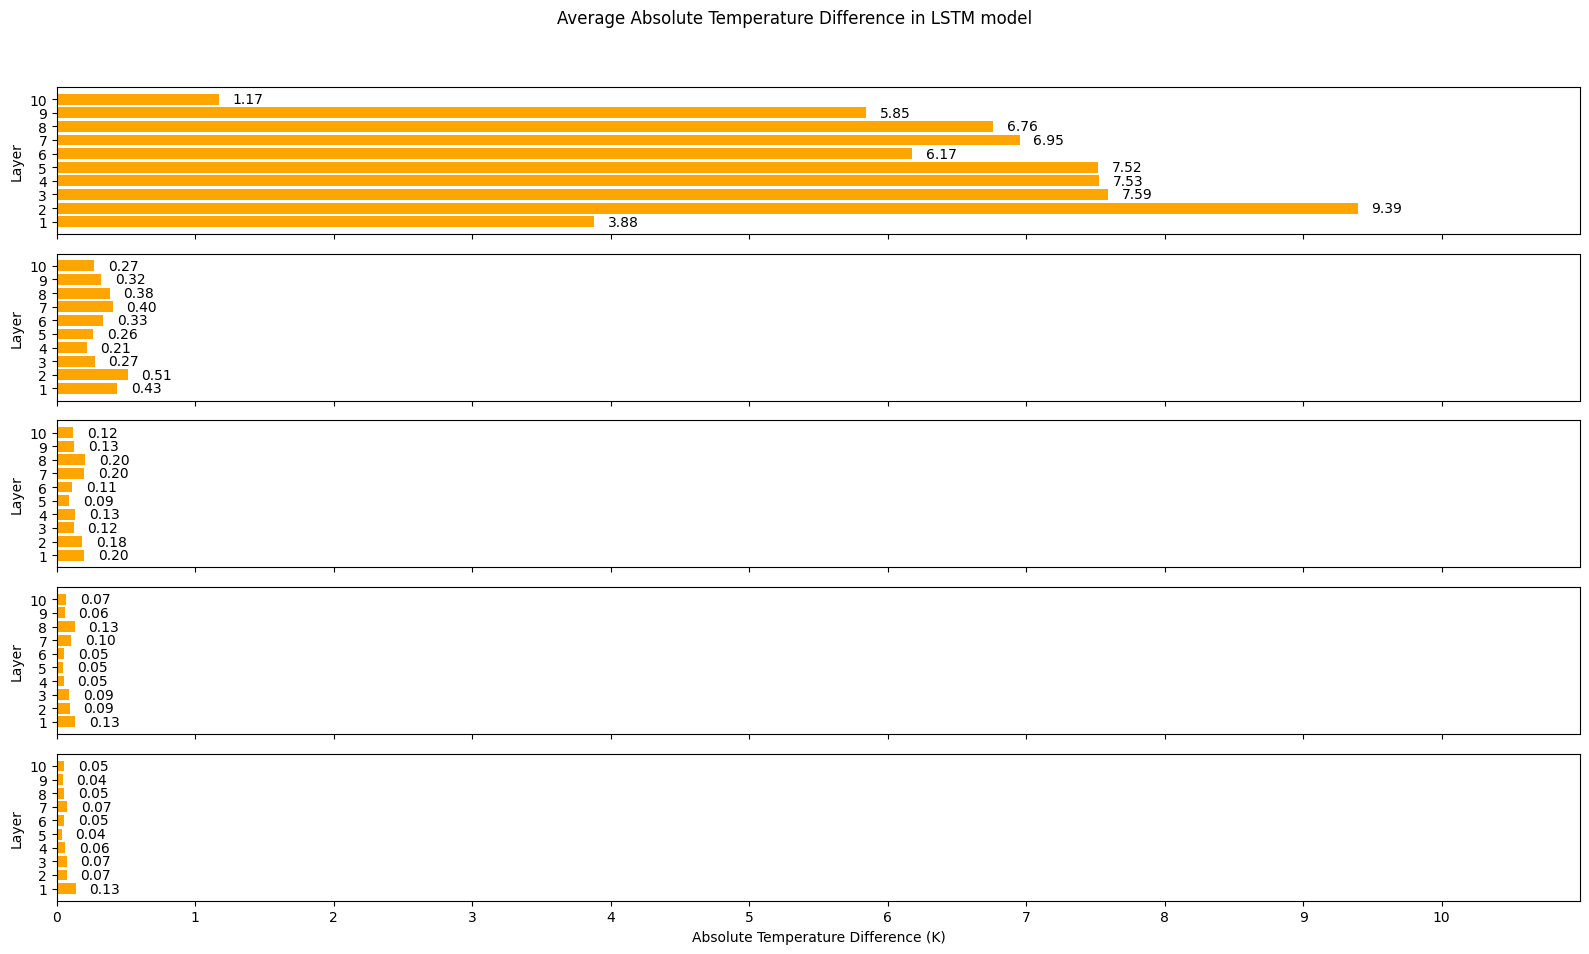

In [21]:
# Set up the figure and subplots
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(16, 10), sharex=True)
fig.suptitle("Average Absolute Temperature Difference in LSTM model")

# Plot each row as a separate horizontal bar graph
for i, ax in enumerate(axes):
    avg_temp_diff = avg_temp_time[i]
    x = np.arange(1, 11, step=1)
    bars = ax.barh(x, avg_temp_diff, color='orange')

    # Set the y-ticks for layers
    ax.set_yticks(np.arange(1, 11, step=1))

    # Set the labels for y-axis
    ax.set_ylabel("Layer")

    # Add labels to each bar
    for bar in bars:
        width = bar.get_width()
        ax.text(width + 0.1, bar.get_y() + bar.get_height() / 2, f'{width:.2f}', 
                ha='left', va='center')

# Set the x-axis limits and labels for the last subplot
axes[-1].set_xlim(math.floor(np.min(avg_temp_time)), math.ceil(np.max(avg_temp_time)) + 1)
axes[-1].set_xlabel("Absolute Temperature Difference (K)")

# Set x-ticks for temperature difference
axes[-1].set_xticks(np.arange(math.floor(np.min(avg_temp_time)), math.ceil(np.max(avg_temp_time)) + 1, step=1))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Hyperparameter Tuning

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, LSTM, Bidirectional, TimeDistributed
from tensorflow.keras.optimizers import Nadam, Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import kerastuner as kt

# Define the model building function for Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(5, 71)))

    # Hyperparameter for number of LSTM layers
    for i in range(hp.Int('num_layers', 1, 8)):
        model.add(Bidirectional(LSTM(
            units=hp.Int(f'units_{i}', min_value=8, max_value=512, step=32),
            activation=hp.Choice('activation', ['relu', 'tanh']),
            return_sequences=True
        )))

    model.add(TimeDistributed(Dense(10, activation='linear')))

    # Choose the optimizer
    optimizer = hp.Choice('optimizer', ['nadam', 'adam', 'rmsprop'])
    if optimizer == 'nadam':
        optimizer = Nadam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4]))
    elif optimizer == 'adam':
        optimizer = Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4]))
    else:
        optimizer = RMSprop(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4]))

    model.compile(optimizer=optimizer, loss='mae', metrics=['accuracy'])
    return model

# Set up Keras Tuner with Hyperband
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=50,
    factor=3,
    directory='hyperband_lstm',
    project_name='hyperparameter_tuning_lstm'
)

# Define early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Run the tuner search
tuner.search(
    X_train_scaled, y_train_scaled,
    epochs=100,
    batch_size=hp.Choice('batch_size', [64, 128, 256, 512]),
    validation_data=(X_val_scaled, y_val_scaled),
    callbacks=[early_stopping, reduce_lr]
)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. The optimal number of LSTM layers is {best_hps.get('num_layers')}.
The optimal number of units in the LSTM layers are {', '.join(str(best_hps.get(f'units_{i}')) for i in range(best_hps.get('num_layers')))}.
The optimal activation function is {best_hps.get('activation')}.
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
The optimal batch size is {best_hps.get('batch_size')}.
""")

# Build the model with the optimal hyperparameters and train it
model = tuner.hypermodel.build(best_hps)
history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=100,
    batch_size=best_hps.get('batch_size'),
    validation_data=(X_val_scaled, y_val_scaled),
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test_scaled)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')
